In [1]:
# ! wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv

In [2]:
! rm -rf cache_demo_1 cache_demo_2

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/full_dataset/goemotions_1.csv")
df[['text', 'surprise']].sample(3)

,text,surprise
28248,Dammmn girl them make up skills! Your eyes are...,0
51080,00:09 when the glue gun shows up,0
63928,I had to mute cause the sound was making me cry.,0


In [5]:
X = df['text']
y = df['surprise']

In [7]:
import time 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
import numpy as np
from sklearn.model_selection import GridSearchCV

In [10]:
pipe1 = make_pipeline(
    TfidfVectorizer(),
    TruncatedSVD(n_components=10),
    LogisticRegression(C=0.1),
    memory="cache_demo_1"
)

pipe1

Pipeline(memory='cache_demo_1',
         steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('truncatedsvd', TruncatedSVD(n_components=10)),
                ('logisticregression', LogisticRegression(C=0.1))])

In [11]:
grid1 = GridSearchCV(
    pipe1, 
    param_grid={
        "logisticregression__C": np.logspace(0.01, 2, 5), 
        "truncatedsvd__n_components": [10, 20, 50, 100]
    },
    scoring={"f1_score": make_scorer(f1_score)},
    cv=5,
    refit=False,
    n_jobs=-1
)

In [12]:
%%time 

grid1.fit(X, y)

CPU times: user 1.52 s, sys: 709 ms, total: 2.23 s
Wall time: 21.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(memory='cache_demo_1',
                                steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('truncatedsvd',
                                        TruncatedSVD(n_components=10)),
                                       ('logisticregression',
                                        LogisticRegression(C=0.1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([  1.02329299,   3.21736253,  10.11579454,  31.80533688,
       100.        ]),
                         'truncatedsvd__n_components': [10, 20, 50, 100]},
             refit=False,
             scoring={'f1_score': make_scorer(f1_score, response_method='predict')})

But just for comparison... let's make a new pipeline.

In [14]:
pipe2 = make_pipeline(
    TfidfVectorizer(),
    TruncatedSVD(n_components=10),
    LogisticRegression(C=0.1),
    memory="cache_demo_2"
)

In [17]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

grid2 = RandomizedSearchCV(
    pipe2, 
    n_iter=20,
    param_distributions={
        "logisticregression__C": np.logspace(0.001, 2, 100), 
        "truncatedsvd__n_components": [10, 20, 50, 100]
    },
    scoring={"f1_score": make_scorer(f1_score)},
    cv=5,
    refit=False,
    n_jobs=-1
)

In [18]:
%%time 

grid2.fit(X, y)

CPU times: user 1.28 s, sys: 677 ms, total: 1.96 s
Wall time: 15.5 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(memory='cache_demo_2',
                                      steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('truncatedsvd',
                                              TruncatedSVD(n_components=10)),
                                             ('logisticregression',
                                              LogisticRegression(C=0.1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([  1.00230524,   1.05000633,   1.09997759,   1.15232705,
         1.2071679 ,   1.26461869,   1.324...
        41.33838782,  43.30573904,  45.36671924,  47.52578434,
        49.78760234,  52.1570634 ,  54.6392904 ,  57.23965002,
        59.96376437,  62.81752309,  65.80709615,  68.93894715,
        72.21984727,  75.65688998,  79.25750633,  83.029481  ,
        86.98096917,  91.12051415,  95.45706582, 100.        ]),
                                        'truncatedsvd__n_components': [10, 20,
                                                                       50,
                                                                       100]},
                   refit=False,
                   scoring={'f1_score': make_scorer(f1_score, response_method='predict')})

In [3]:
import numpy as np

In [106]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X, y = load_breast_cancer(return_X_y=True)

In [107]:
grid_full = GridSearchCV(
    HistGradientBoostingClassifier(), 
    param_grid={
        "max_iter": np.linspace(10, 200, 10).astype(int), 
        "l2_regularization": np.linspace(0, 4, 10)
    },
    cv=5,
    refit=False,
    n_jobs=-1
)

In [112]:
grid_rand = RandomizedSearchCV(
    HistGradientBoostingClassifier(), 
    n_iter=100,
    param_distributions={
        "max_iter": np.linspace(10, 200, 100).astype(int), 
        "l2_regularization": np.linspace(0, 4, 50)
    },
    cv=5,
    refit=False,
    n_jobs=-1
)

In [113]:
%%time 

grid_full.fit(X, y);

CPU times: user 392 ms, sys: 134 ms, total: 525 ms
Wall time: 7.71 s


In [115]:
%%time 

grid_rand.fit(X, y);

CPU times: user 296 ms, sys: 98.2 ms, total: 394 ms
Wall time: 7.5 s


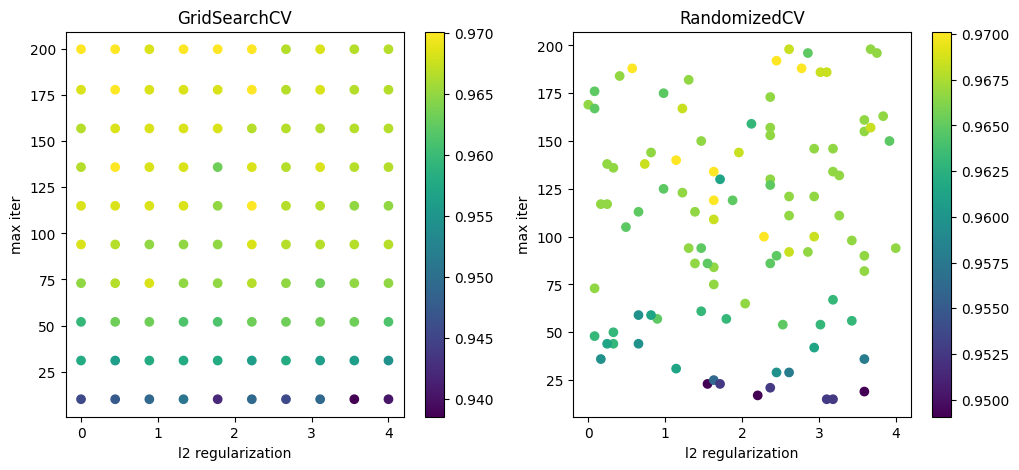

In [117]:
import matplotlib.pylab as plt

plt.figure(figsize=(12, 5))

plt.subplot(121)
p = grid_full.cv_results_
plt.scatter(p['param_l2_regularization'], p['param_max_iter'], c=p['mean_test_score'])
plt.colorbar();
plt.xlabel("l2 regularization")
plt.ylabel("max iter")
plt.title("GridSearchCV")

plt.subplot(122)
p = grid_rand.cv_results_
plt.scatter(p['param_l2_regularization'], p['param_max_iter'], c=p['mean_test_score'])
plt.colorbar();
plt.xlabel("l2 regularization")
plt.ylabel("max iter")
plt.title("RandomizedCV");